In [186]:
import pandas as pd
import numpy as np
from scipy import stats
import warnings

In [187]:
df = pd.read_csv('data/cuped_info含缺失值标签0427_0524.csv') # pre-4 WEEK
df_ratio = pd.read_csv("data/找选接确完车主量.csv")

# 1-数据验证 Data Validation

In [188]:
#SRM检验
def srm_test(data):
    data_srm = data.groupby('group_name').size().reset_index().rename(columns={0:'cnt'})
    observed = data_srm['cnt'].values
    expected = [0.5 * observed.sum()] * 2  
    chi2_stat, p_value = stats.chisquare(f_obs=observed, f_exp=expected)
    if p_value > 0.05:
        print('已通过SRM检验')
        print(f'p值: {p_value:.4f}>0.05')
    else:
        print('未通过SRM检验')
        print(f'p值: {p_value:.4f}<=0.05')

In [189]:
#切换组别核查
def check_group_switch(data):
    # 检查每个 user_id 是否有唯一的 group_name
    group_counts = data.groupby('user_id')['group_name'].nunique()
    
    # 找出有多个 group_name 的 user_id
    switched_users = group_counts[group_counts > 1].index.tolist()
    cnt = len(data['user_id'].unique().tolist())

    if len(switched_users) == 0:
        return print('无切换组别情况')
    elif len(switched_users) <= cnt * 0.05:
        #删除切换组别的user_id
        for user_id in switched_users :
            data = data[data['user_id'] != user_id]
        return print('有少量切换组别情况,已删除异常样本', switched_users)
    else:
        return print('切换组别情况过多,请检查实验')

In [190]:
srm_test(df)
check_group_switch(df)

已通过SRM检验
p值: 0.7195>0.05
无切换组别情况


# 2-数据处理 Data Processing

## 2.1-去除Outlier

### GMV

In [134]:
# 方法1:使用IQR来排除outliers
def outlier_iqr(df, column_name):
    import pandas as pd
    
    Q1 = df[df[column_name] != 0][column_name].quantile(0.25)
    Q3 = df[df[column_name] != 0][column_name].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    df_filtered_iqr = df[(df[column_name] == 0) | ((df[column_name] >= lower_bound) & (df[column_name] <= upper_bound))]

    # 导出保存数据
    # df_filtered_iqr.to_csv('outlier_removed_iqr.csv', index=False)
    return df_filtered_iqr
df_filtered_iqr = outlier_iqr(df, 'gmv_after')

In [135]:
# 方法2:使用3*std dev 来排除outliers
# Calculate the mean and standard deviation
def outlier_sd(df, column_name):
    mean = df[df[column_name] != 0][column_name].mean()
    std_dev = df[df[column_name] != 0][column_name].std()
    
    lower_bound_sd = mean - 3 * std_dev
    upper_bound_sd = mean + 3 * std_dev
    df_filtered_sd = df[(df[column_name] == 0) | ((df[column_name] >= lower_bound_sd) & (df[column_name] <= upper_bound_sd))]
    
    # 导出保存数据
    # df_filtered_sd.to_csv('outlier_removed_sd.csv', index=False)
    return df_filtered_sd
df_filtered_sd = outlier_sd(df, 'gmv_after')

In [136]:
import matplotlib.pyplot as plt
def summary_stats(data, column):
    return {
        '数据大小': data.shape[0],
        '平均值': data[column].mean(),
        '中位数': data[column].median(),
        'min': data[column].min(),
        'max': data[column].max(),
        'std_dev': data[column].std()
    }

original_stats = summary_stats(df, 'gmv_after')
iqr_stats = summary_stats(df_filtered_iqr, 'gmv_after')
sd_stats = summary_stats(df_filtered_sd, 'gmv_after')

print("\n(gmv)原数据统计信息:")
for key, value in original_stats.items():
    print(f'{key}: {value}')

print("\n(gmv)iqr方法后数据统计信息:")
for key, value in iqr_stats.items():
    print(f'{key}: {value}')

print("\n(gmv)sd方法后数据统计信息:")
for key, value in sd_stats.items():
    print(f'{key}: {value}')


(gmv)原数据统计信息:
数据大小: 4670552
平均值: 97.27483670452652
中位数: 0.0
min: 0.0
max: 17832.800000000003
std_dev: 382.32168252625365

(gmv)iqr方法后数据统计信息:
数据大小: 4535521
平均值: 43.32367796555229
中位数: 0.0
min: 0.0
max: 888.8
std_dev: 122.18292731559377

(gmv)sd方法后数据统计信息:
数据大小: 4641696
平均值: 75.65110768779333
中位数: 0.0
min: 0.0
max: 2478.9
std_dev: 252.09303318555385


In [141]:
print(f'sd:{100*(4670552-4641696)/4670552}')
print(f'iqr:{100*(4670552-4535521)/4670552}')

sd:0.6178284708103025
iqr:2.891114369350775


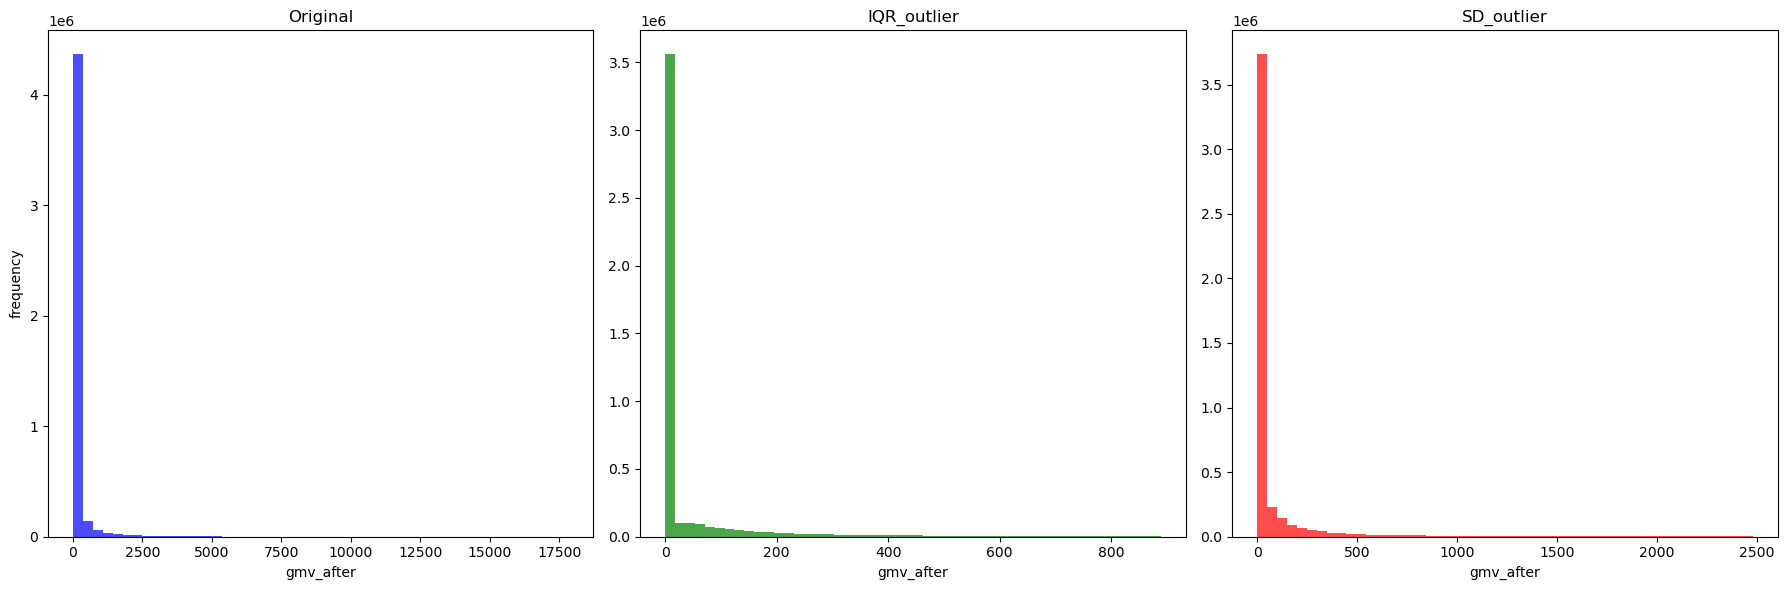

In [137]:
# 画图（不剔除0）
plt.figure(figsize=(18, 6))

# Plot original data
plt.subplot(1, 3, 1)
plt.hist(df['gmv_after'], bins=50, color='blue', alpha=0.7)
plt.title('Original')
plt.xlabel('gmv_after')
plt.ylabel('frequency')

# Plot IQR filtered data
plt.subplot(1, 3, 2)
plt.hist(df_filtered_iqr['gmv_after'], bins=50, color='green', alpha=0.7)
plt.title('IQR_outlier')
plt.xlabel('gmv_after')

# Plot SD filtered data
plt.subplot(1, 3, 3)
plt.hist(df_filtered_sd['gmv_after'], bins=50, color='red', alpha=0.7)
plt.title('SD_outlier')
plt.xlabel('gmv_after')

plt.tight_layout()
plt.show()

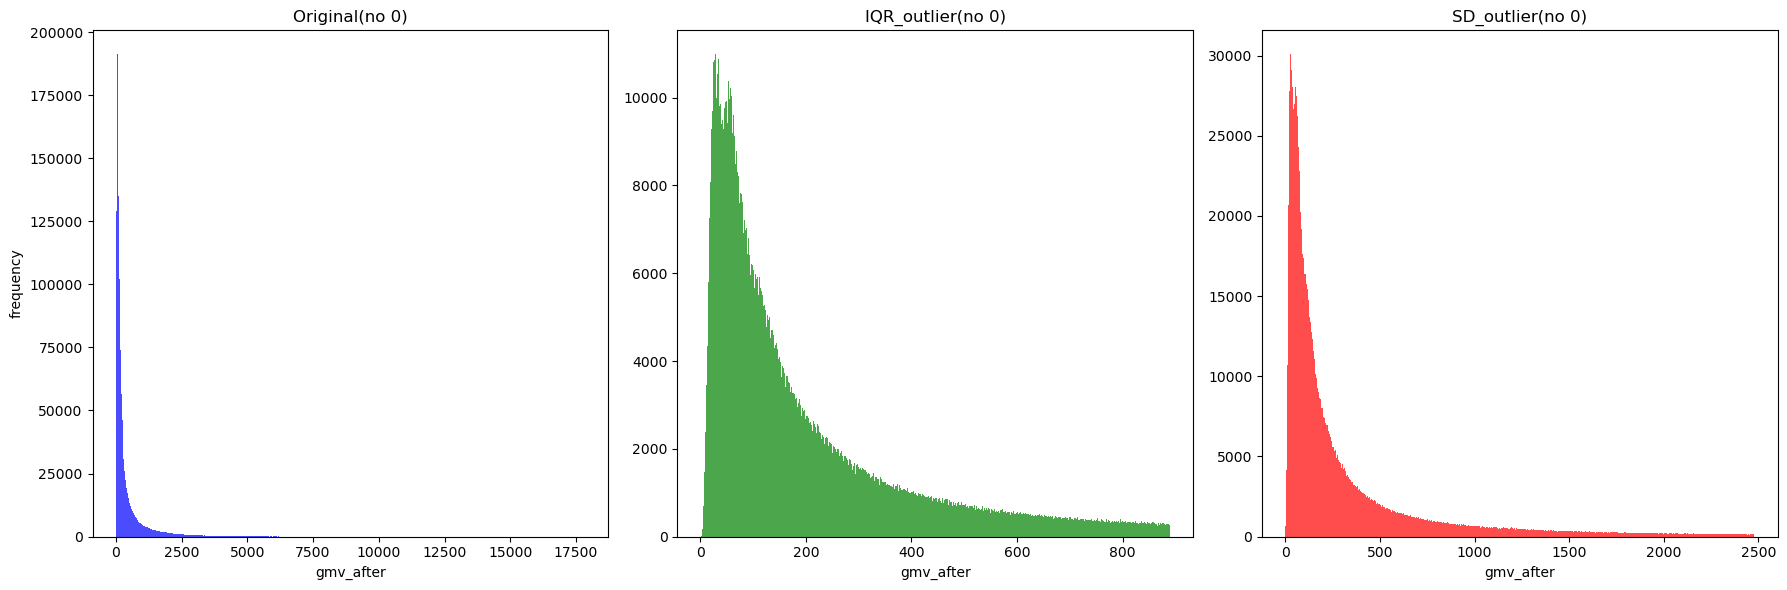

In [138]:
# 画图

# Exclude 0 entries for plotting
df_no_zeros = df[df['gmv_after'] != 0]
df_filtered_iqr_no_zeros = df_filtered_iqr[df_filtered_iqr['gmv_after'] != 0]
df_filtered_sd_no_zeros = df_filtered_sd[df_filtered_sd['gmv_after'] != 0]

# Plot distributions without 0 entries
plt.figure(figsize=(18, 6))

# Plot original data
plt.subplot(1, 3, 1)
plt.hist(df_no_zeros['gmv_after'], bins=500, color='blue', alpha=0.7)
plt.title('Original(no 0)')
plt.xlabel('gmv_after')
plt.ylabel('frequency')

# Plot IQR filtered data
plt.subplot(1, 3, 2)
plt.hist(df_filtered_iqr_no_zeros['gmv_after'], bins=500, color='green', alpha=0.7)
plt.title('IQR_outlier(no 0)')
plt.xlabel('gmv_after')

# Plot SD filtered data
plt.subplot(1, 3, 3)
plt.hist(df_filtered_sd_no_zeros['gmv_after'], bins=500, color='red', alpha=0.7)
plt.title('SD_outlier(no 0)')
plt.xlabel('gmv_after')

plt.tight_layout()
plt.show()


### 人均累计订单量

In [147]:
df_filtered_iqr = outlier_iqr(df, 'ordercnt_after')
df_filtered_sd = outlier_sd(df, 'ordercnt_after')

# Calculate summary statistics
original_stats = summary_stats(df, 'ordercnt_after')
iqr_stats = summary_stats(df_filtered_iqr, 'ordercnt_after')
sd_stats = summary_stats(df_filtered_sd, 'ordercnt_after')

# Print summary statistics
print("\n(ordercnt)原数据统计信息:")
for key, value in original_stats.items():
    print(f'{key}: {value}')

print("\n(ordercnt)iqr方法后数据统计信息:")
for key, value in iqr_stats.items():
    print(f'{key}: {value}')

print("\n(ordercnt)sd方法后数据统计信息:")
for key, value in sd_stats.items():
    print(f'{key}: {value}')


(ordercnt)原数据统计信息:
数据大小: 4670552
平均值: 1.3978688172190354
中位数: 0.0
min: 0.0
max: 135.0
std_dev: 5.000459314625813

(ordercnt)iqr方法后数据统计信息:
数据大小: 4541202
平均值: 0.698582665999002
中位数: 0.0
min: 0.0
max: 13.0
std_dev: 1.9023246637131146

(ordercnt)sd方法后数据统计信息:
数据大小: 4641600
平均值: 1.1257169941399516
中位数: 0.0
min: 0.0
max: 32.0
std_dev: 3.5176318509978857


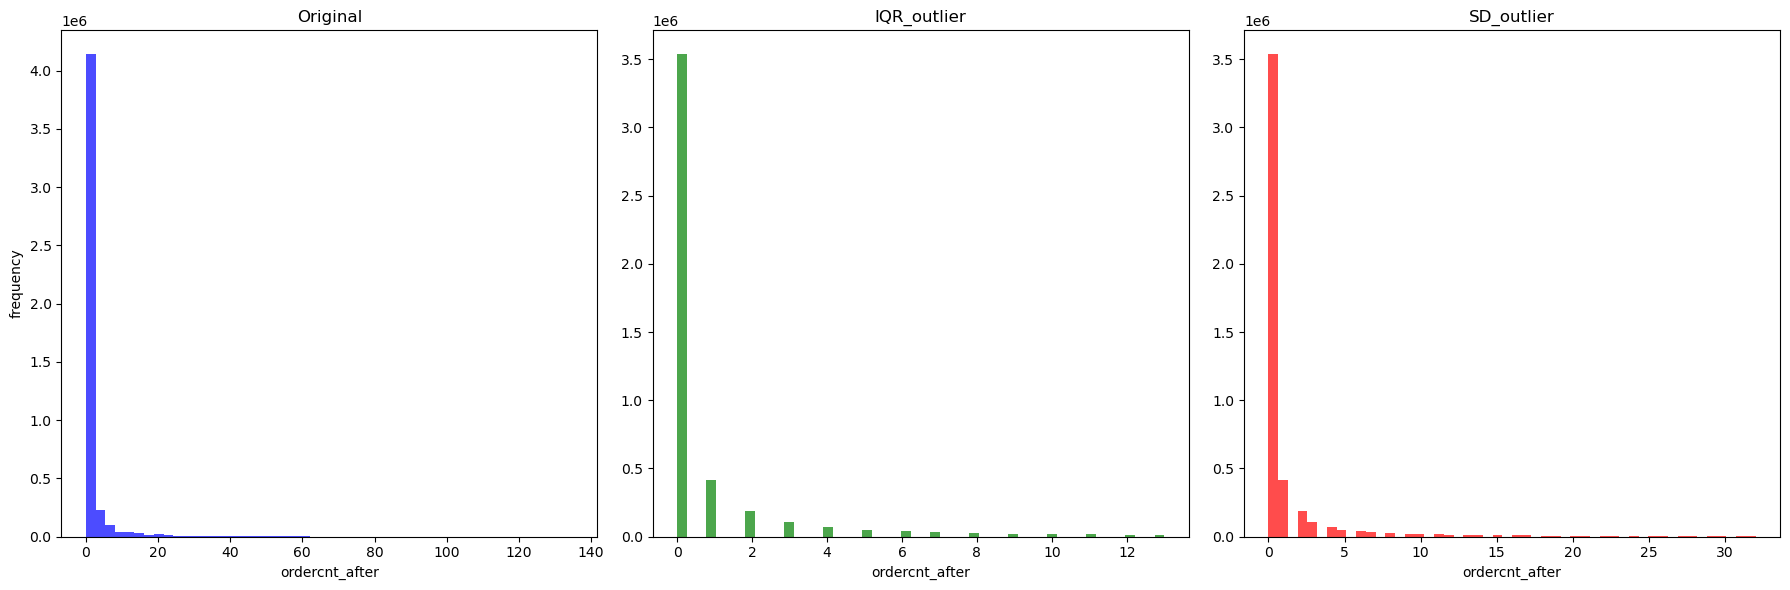

In [132]:
# 画图（不剔除0）
plt.figure(figsize=(18, 6))

# Plot original data
plt.subplot(1, 3, 1)
plt.hist(df['ordercnt_after'], bins=50, color='blue', alpha=0.7)
plt.title('Original')
plt.xlabel('ordercnt_after')
plt.ylabel('frequency')

# Plot IQR filtered data
plt.subplot(1, 3, 2)
plt.hist(df_filtered_iqr['ordercnt_after'], bins=50, color='green', alpha=0.7)
plt.title('IQR_outlier')
plt.xlabel('ordercnt_after')

# Plot SD filtered data
plt.subplot(1, 3, 3)
plt.hist(df_filtered_sd['ordercnt_after'], bins=50, color='red', alpha=0.7)
plt.title('SD_outlier')
plt.xlabel('ordercnt_after')

plt.tight_layout()
plt.show()

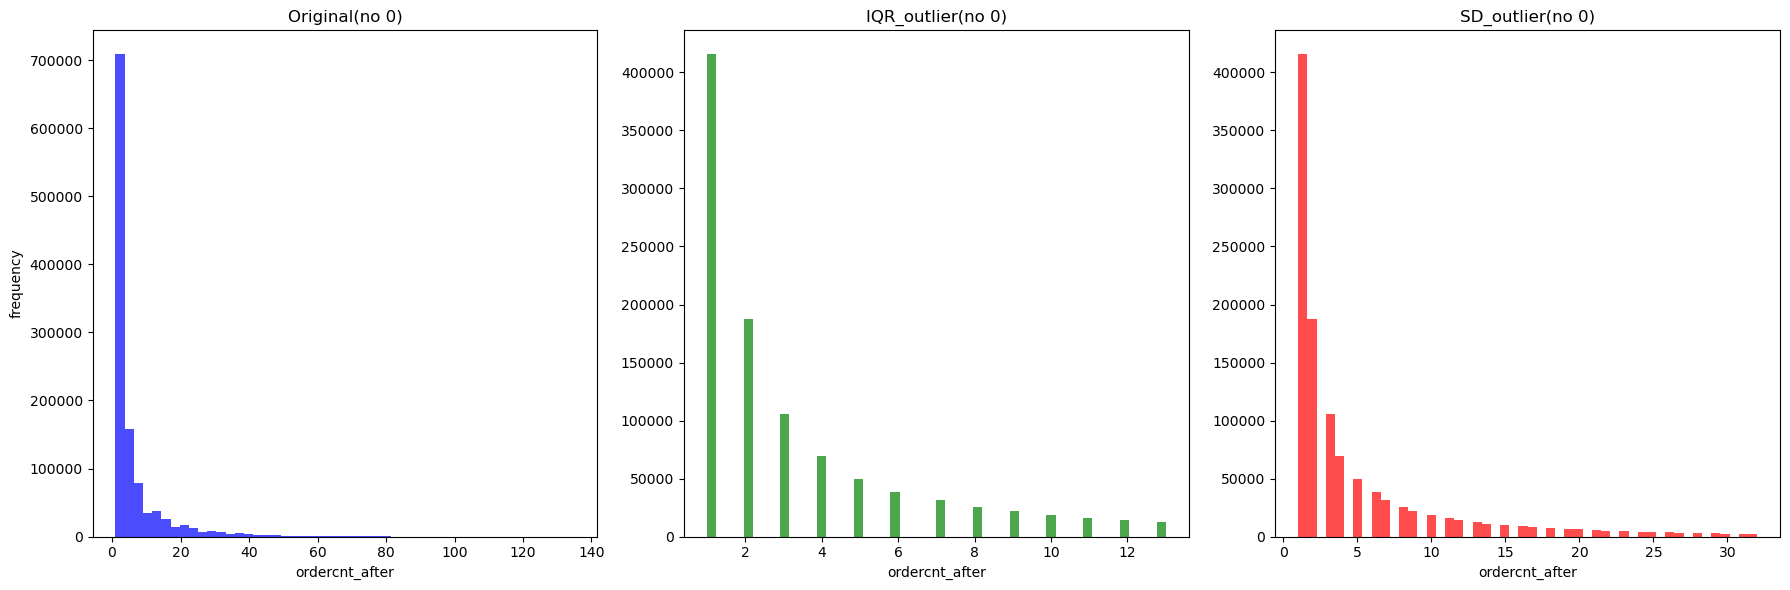

In [133]:
# 画图

# Exclude 0 entries for plotting
df_no_zeros = df[df['ordercnt_after'] != 0]
df_filtered_iqr_no_zeros = df_filtered_iqr[df_filtered_iqr['ordercnt_after'] != 0]
df_filtered_sd_no_zeros = df_filtered_sd[df_filtered_sd['ordercnt_after'] != 0]

# Plot distributions without 0 entries
plt.figure(figsize=(18, 6))

# Plot original data
plt.subplot(1, 3, 1)
plt.hist(df_no_zeros['ordercnt_after'], bins=50, color='blue', alpha=0.7)
plt.title('Original(no 0)')
plt.xlabel('ordercnt_after')
plt.ylabel('frequency')

# Plot IQR filtered data
plt.subplot(1, 3, 2)
plt.hist(df_filtered_iqr_no_zeros['ordercnt_after'], bins=50, color='green', alpha=0.7)
plt.title('IQR_outlier(no 0)')
plt.xlabel('ordercnt_after')

# Plot SD filtered data
plt.subplot(1, 3, 3)
plt.hist(df_filtered_sd_no_zeros['ordercnt_after'], bins=50, color='red', alpha=0.7)
plt.title('SD_outlier(no 0)')
plt.xlabel('ordercnt_after')

plt.tight_layout()
plt.show()


## 2.2-计算CUPED指标

In [153]:
def cuped_metric_separate(data0,Y_name,X_name,Y_cuped_name):
    warnings.filterwarnings("ignore")
    # Step 1: Data preprocessing
    data1 = data0[data0['group_name'] == '实验组']
    data2 = data0[data0['group_name'] == '对照组']
    for i in range(len(Y_name)):
    # Step 2: Calculate theta for treatment group
        var_t = data1[data1['access_tag']==1][X_name[i]].var()
        cov_t = data1[data1['access_tag']==1][X_name[i]].cov(data1[data1['access_tag']==1][Y_name[i]])
        theta_t = cov_t / var_t
        mean_t = data1[data1['access_tag']==1][X_name[i]].mean()
        data1[X_name[i]] =data1.apply(lambda row: mean_t if row['access_tag']==0 else row[X_name[i]],axis=1)
        data1[Y_cuped_name[i]] = data1[Y_name[i]] - theta_t * (data1[X_name[i]] - mean_t)  #- mean_t

    # Step 3: Calculate theta for control group
        var_c = data2[data2['access_tag']==1][X_name[i]].var()
        cov_c = data2[data2['access_tag']==1][X_name[i]].cov(data2[data2['access_tag']==1][Y_name[i]])
        theta_c = cov_c / var_c
        mean_c = data2[data2['access_tag']==1][X_name[i]].mean()        
        data2[X_name[i]] =data2.apply(lambda row: mean_c if row['access_tag']==0 else row[X_name[i]],axis=1)
        data2[Y_cuped_name[i]] = data2[Y_name[i]] - theta_c * (data2[X_name[i]] - mean_c) #- mean_c

    # Step 4: Combine data
    data0 = pd.concat([data1, data2], axis=0)
    return data0

def cuped_metric_pool(data0,Y_name,X_name,Y_cuped_name):
    warnings.filterwarnings("ignore")
    for i in range(len(Y_name)):
        var_X = data0[data0['access_tag']==1][X_name[i]].var()
        cov = data0[data0['access_tag']==1][X_name[i]].cov(data0[data0['access_tag']==1][Y_name[i]])
        theta = cov / var_X
        mean_X = data0[data0['access_tag']==1][X_name[i]].mean()
        data0[X_name[i]] =data0.apply(lambda row: mean_X if row['access_tag']==0 else row[X_name[i]],axis=1)
        data0[Y_cuped_name[i]] = data0[Y_name[i]] - theta * (data0[X_name[i]] - mean_X) #- mean_X
    return data0

In [154]:
## cuped生成函数
def cuped_process(data,cal_type):
    #生成CUPED指标
    if cal_type == 'separate':
        data= cuped_metric_separate(data,['ordercnt_after','gmv_after'],['ordercnt_before','gmv_before'],['ordercnt_cuped','gmv_cuped'])[['group_name','access_tag','user_id','enter_date','ordercnt_cuped','gmv_cuped']]
    elif cal_type == 'pool':    
        data = cuped_metric_pool(data,['ordercnt_after','gmv_after'],['ordercnt_before','gmv_before'],['ordercnt_cuped','gmv_cuped'])[['group_name','access_tag', 'enter_date', 'user_id','ordercnt_cuped','gmv_cuped']]
    #分层计算均值和方差
    #1.1-计算进行CUPED调整的样本的方差
    data_agg_i1 = data[data['access_tag'] == 1].groupby(['group_name']).agg(
        avg_order_cnt_1=('ordercnt_cuped', 'mean'), var_order_cnt_1=('ordercnt_cuped', 'var'),
        avg_gmv_1=('gmv_cuped', 'mean'), var_gmv_1=('gmv_cuped', 'var')).reset_index()
     #1.2-计算未进行CUPED调整的样本的方差
    data_agg_i0 = data[data['access_tag'] == 0].groupby(['group_name']).agg(
        avg_order_cnt_0=('ordercnt_cuped', 'mean'), var_order_cnt_0=('ordercnt_cuped', 'var'),
        avg_gmv_0=('gmv_cuped', 'mean'), var_gmv_0=('gmv_cuped', 'var')).reset_index()
    data_agg_i = data_agg_i1.merge(data_agg_i0, on=['group_name'], how='left')

    data_prop = data.groupby(['group_name','access_tag']).size().reset_index().rename(columns={0: 'cnt_'})
    data_prop['total_cnt'] = data_prop.groupby(['group_name'])['cnt_'].transform('sum')
    data_prop['prop'] = data_prop['cnt_'] / data_prop['total_cnt']
    data_prop['access_tag'] = pd.Categorical(data_prop['access_tag'], categories=[0, 1], ordered=True)
    data_wide = data_prop.pivot(index=['group_name'], columns='access_tag', values='prop').reset_index()
    data_wide.columns = ['group_name', 'prop0', 'prop1']
    data_agg_i = data_agg_i.merge(data_wide, on=['group_name'], how='left')

    data_agg_i['avg_order_cnt'] = data_agg_i['avg_order_cnt_1']*data_agg_i['prop1'] + data_agg_i['avg_order_cnt_0']*data_agg_i['prop0']
    data_agg_i['std_order_cnt'] = np.sqrt(data_agg_i['var_order_cnt_1']*data_agg_i['prop1'] + data_agg_i['var_order_cnt_0']*data_agg_i['prop0'])
    data_agg_i['avg_gmv'] = data_agg_i['avg_gmv_1']*data_agg_i['prop1'] + data_agg_i['avg_gmv_0']*data_agg_i['prop0']
    data_agg_i['std_gmv'] = np.sqrt(data_agg_i['var_gmv_1']*data_agg_i['prop1'] + data_agg_i['var_gmv_0']*data_agg_i['prop0'])
    cnt_i = data.groupby(['group_name']).size().reset_index().rename(columns={0: 'cnt'})
    data_agg_i = data_agg_i.merge(cnt_i, on=['group_name'], how='left')
    return data_agg_i

In [155]:
#生成聚合数据结果（用于样本量足够的情形）
data_agg = cuped_process(df,'pool')
data_agg.head(2)

,group_name,avg_order_cnt_1,var_order_cnt_1,avg_gmv_1,var_gmv_1,avg_order_cnt_0,var_order_cnt_0,avg_gmv_0,var_gmv_0,prop0,prop1,avg_order_cnt,std_order_cnt,avg_gmv,std_gmv,cnt
0,实验组,2.759924,16.203328,190.075909,88565.354699,0.168535,1.143513,13.093204,7119.215459,0.524139,0.475861,1.401676,2.882689,97.312416,214.187482,2335664
1,对照组,2.752255,16.075097,190.347818,89736.951252,0.165019,1.109164,12.980715,7230.763054,0.524960,0.475040,1.394060,2.866808,97.237245,215.463526,2334888


In [156]:
#含CUPED指标（未做分层处理）（用于样本量不足的情形）
df.head()

,group_name,user_id,enter_date,access_tag,ordercnt_before,ordercnt_after,gmv_before,gmv_after,ordercnt_cuped,gmv_cuped
0,实验组,1000080708,20240525,0,8.708229,0.0,5597.790601,0.0,0.000000,0.000000
1,实验组,1000205418,20240525,1,171.000000,23.0,125811.200000,2639.4,-27.476896,-891.801811
2,实验组,1000218110,20240530,0,8.708229,0.0,5597.790601,0.0,0.000000,0.000000
3,实验组,1000232871,20240526,0,8.708229,0.0,5597.790601,0.0,0.000000,0.000000
4,实验组,1000237653,20240604,0,8.708229,0.0,5597.790601,0.0,0.000000,0.000000


# 3-实验灵敏度

### 3.1-最小样本量计算（连续型/比率型）

In [157]:
import numpy as np
import pandas as pd
from statsmodels.stats.power import TTestIndPower
def calculate_sample_size_contratio(data,metric_name):
    control = data[data['group_name'] == '对照组'][metric_name]
    treatment = data[data['group_name'] == '实验组'][metric_name]

    # Calculate means
    mean_control = np.mean(control)
    mean_treatment = np.mean(treatment)

    # Calculate standard deviations
    std_control = np.std(control, ddof=1)  # ddof=1 for sample standard deviation
    std_treatment = np.std(treatment, ddof=1)

    # Calculate pooled standard deviation
    n_control = len(control)
    n_treatment = len(treatment)
    pooled_std = np.sqrt(((n_control - 1) * std_control**2 + (n_treatment - 1) * std_treatment**2) / (n_control + n_treatment - 2))

    # Calculate Cohen's d
    cohens_d = (mean_treatment - mean_control) / pooled_std

    # Print effect size
    print(f"Cohen's d: {cohens_d:.2f}")

    # Parameters for power analysis
    alpha = 0.05  # significance level
    powers = [0.70, 0.80, 0.90, 0.95, 0.99]

    analysis = TTestIndPower()
    # Calculate required sample sizes
    sample_sizes = {power: analysis.solve_power(effect_size=cohens_d, power=power, alpha=alpha, ratio=1.0) for power in powers}
    sample_sizes_df = pd.DataFrame(list(sample_sizes.items()), columns=['Power', 'Required Sample Size'])
    samplesize_col = calculated_sample_size['Required Sample Size']

    even_samplesize_col = []
    for samplesize in samplesize_col:
        samplesize = np.round(samplesize,0)
        if samplesize % 2 ==1:
            samplesize += 1
        even_samplesize_col.append(samplesize)
    sample_sizes_df['Required Sample Size'] = even_samplesize_col
    print(sample_sizes_df)
    return sample_sizes_df
'''
solve_power方法返回的样本量是总样本量，即实验组和对照组样本量之和。如果ratio参数设置为1.0，
则返回的样本量应该被平均分配给两个组，也就是说，每个组的样本量应该是返回值的一半。如果ratio不是1.0，
则需要根据这个比率来调整每个组的样本量。
'''
calculated_sample_size = calculate_sample_size_contratio(df,'ordercnt_after')


Cohen's d: 0.00
   Power  Required Sample Size
0   0.70             2123256.0
1   0.80             2700118.0
2   0.90             3614700.0
3   0.95             4470362.0
4   0.99             6320386.0


### 3.2-最小样本量计算（比例型）

In [170]:
from statsmodels.stats.power import NormalIndPower
from statsmodels.stats.proportion import proportion_effectsize

# 计算比例
data = df_ratio.copy()
data['找完率'] = data['完单车主量'] / data['找单车主量']

# Extract proportions
p_control = data[data['group_name'] == '对照组']['找完率'].values[0]
p_experiment = data[data['group_name'] == '实验组']['找完率'].values[0]

# Print proportions
print(f"Control Group Proportion: {p_control:.2f}")
print(f"Experiment Group Proportion: {p_experiment:.2f}")

# Calculate Cohen's h (effect size for proportions)
effect_size = proportion_effectsize(p_experiment, p_control)

# Print effect size
print(f"Cohen's h: {effect_size:.2f}")

# Parameters for power analysis
alpha = 0.05  # significance level
powers = [0.70, 0.80, 0.90, 0.95, 0.99]

# Create an instance of the power analysis class
analysis = NormalIndPower()

# Calculate required sample sizes
sample_sizes = {power: analysis.solve_power(effect_size=effect_size, power=power, alpha=alpha, ratio=1.0) for power in powers}

# Convert results to a DataFrame for easy viewing
sample_sizes_df = pd.DataFrame(list(sample_sizes.items()), columns=['Power', 'Required Sample Size'])
print(sample_sizes_df)



Control Group Proportion: 0.27
Experiment Group Proportion: 0.27
Cohen's h: 0.00
   Power  Required Sample Size
0   0.70          8.489263e+05
1   0.80          1.079569e+06
2   0.90          1.445240e+06
3   0.95          1.787353e+06
4   0.99          2.527035e+06


# 4-假设检验

## 4.1-样本量足够

### 4.1.1-连续型 （welch's t-test)

In [193]:
import numpy as np
import pandas as pd
from scipy.stats import ks_2samp

def check_normality(df, column_name, sample_size_threshold=30):
    exp_data = df[df['group_name'] == '实验组'][column_name]
    ctrl_data = df[df['group_name'] == '对照组'][column_name]
    
    # Check sample sizes
    n_exp = len(exp_data)
    n_ctrl = len(ctrl_data)
    
    print(f"Sample sizes - Experiment group: {n_exp}, Control group: {n_ctrl}")
    
    if n_exp > sample_size_threshold and n_ctrl > sample_size_threshold:
        print("样本量足够大，中心极限理论导致我们可以假设数据的正态分布")
        return True

    # Kolmogorov-Smirnov test 检查是否偏态
    mean_exp, std_exp = np.mean(exp_data), np.std(exp_data, ddof=1)
    mean_ctrl, std_ctrl = np.mean(ctrl_data), np.std(ctrl_data, ddof=1)
    
    ks_stat_exp, p_value_exp = ks_2samp(exp_data, np.random.normal(mean_exp, std_exp, len(exp_data)))
    ks_stat_ctrl, p_value_ctrl = ks_2samp(ctrl_data, np.random.normal(mean_ctrl, std_ctrl, len(ctrl_data)))
    
    print(f"Kolmogorov-Smirnov Test （实验组）: Statistic = {ks_stat_exp:.4f}, P-value = {p_value_exp:.4f}")
    print(f"Kolmogorov-Smirnov Test （对照组）: Statistic = {ks_stat_ctrl:.4f}, P-value = {p_value_ctrl:.4f}")
    
    if p_value_exp > 0.05 and p_value_ctrl > 0.05:
        print("实验组和对照组都是正态分布")
        return True
    else:
        print("实验组/对照组中至少有一个不是正态分布，需要使用曼惠特尼U检验")
        return False

is_normal_gmv = check_normality(df, 'gmv_after')
print(f"是否正态分布 (gmv): {is_normal_gmv}")

is_normal_order_cnt = check_normality(df, 'ordercnt_after')
print(f"是否正态分布 (ordercnt): {is_normal_order_cnt}")

Sample sizes - Experiment group: 2335664, Control group: 2334888
样本量足够大，中心极限理论导致我们可以假设数据的正态分布
是否正态分布 (gmv): True
Sample sizes - Experiment group: 2335664, Control group: 2334888
样本量足够大，中心极限理论导致我们可以假设数据的正态分布
是否正态分布 (ordercnt): True


In [178]:
from scipy.stats import ttest_ind_from_stats #使用统计量
### 人均累积gmv （welch's t-test)
mean_exp, std_exp, n_exp =  data_agg[data_agg['group_name']=='实验组'][['avg_gmv','std_gmv','cnt']].values[0] # 实验组的均值、标准差和样本量
mean_ctrl, std_ctrl, n_ctrl =  data_agg[data_agg['group_name']=='对照组'][['avg_gmv','std_gmv','cnt']].values[0]  # 对照组的均值、标准差和样本量

t_stat1, p_value1 = ttest_ind_from_stats(mean1=mean_exp, std1=std_exp, nobs1=n_exp,
                                        mean2=mean_ctrl, std2=std_ctrl, nobs2=n_ctrl,
                                        equal_var=False)
print(f"T-statistic: {t_stat1:.4f}")
print(f"人均累积GMV: P-value: {p_value1:.4f}")
### 人均累积订单量 （welch's t-test)
mean_exp, std_exp, n_exp =  data_agg[data_agg['group_name']=='实验组'][['avg_order_cnt','std_order_cnt','cnt']].values[0] # 实验组的均值、标准差和样本量
mean_ctrl, std_ctrl, n_ctrl =  data_agg[data_agg['group_name']=='对照组'][['avg_order_cnt','std_order_cnt','cnt']].values[0]  # 对照组的均值、标准差和样本量

t_stat2, p_value2 = ttest_ind_from_stats(mean1=mean_exp, std1=std_exp, nobs1=n_exp,
                                        mean2=mean_ctrl, std2=std_ctrl, nobs2=n_ctrl,
                                        equal_var=False)
print(f"\nT-statistic: {t_stat2:.4f}")
print(f"人均累积订单量: P-value: {p_value2:.4f}")

T-statistic: 1.0832
人均累积GMV: P-value: 0.2787

T-statistic: 1.1535
人均累积订单量: P-value: 0.2487


In [160]:
p_values_list = {}
p_values_list['人均累积GMV'] = p_value1
p_values_list['人均累积订单量'] = p_value2
p_values_list

{'人均累积GMV': 0.7053481239780408, '人均累积订单量': 0.004200280518059133}

### 4.1.2比例型（卡方检验&Propotion_Z检验）

In [161]:
df_ratio['找选率'] = df_ratio['选单车主量'] / df_ratio['找单车主量']
df_ratio['选接率'] = df_ratio['接单车主量'] / df_ratio['选单车主量']
df_ratio['接确率'] = df_ratio['确认同行车主量'] / df_ratio['接单车主量']
df_ratio['接完率'] = df_ratio['完单车主量'] / df_ratio['接单车主量']
df_ratio['找完率'] = df_ratio['完单车主量'] / df_ratio['找单车主量']
df_ratio['确完率'] = df_ratio['完单车主量'] / df_ratio['确认同行车主量']
df_ratio.head()

,group_name,找单车主量,选单车主量,接单车主量,确认同行车主量,完单车主量,找选率,选接率,接确率,接完率,找完率,确完率
0,实验组,2123007,1632338,874264,660821,577206,0.768880,0.535590,0.755860,0.660219,0.271881,0.873468
1,对照组,2121454,1632066,871690,657560,573188,0.769315,0.534102,0.754351,0.657559,0.270186,0.871689


In [162]:
#卡方检验
metrics_data = { '找选率': ['找单车主量', '选单车主量'], 
                '选接率': ['选单车主量', '接单车主量'], 
                '接确率': ['接单车主量', '确认同行车主量'], 
                '接完率': ['接单车主量', '完单车主量'], 
                '找完率': ['找单车主量', '完单车主量'], 
                '确完率': ['确认同行车主量', '完单车主量'] }



# Define a function to perform the Chi-Square test
def chi_square_test(observed):
    chi2, p, _, _ = stats.chi2_contingency(observed)
    return chi2, p

# Perform the test for each metric
results = {}

for metric, counts in metrics_data.items():
    group_1 = df_ratio.loc[0, counts].values
    group_2 = df_ratio.loc[1, counts].values
    observed = [group_1, group_2]
    chi2, p = chi_square_test(observed)
    results[metric] = {'chi2': chi2, 'p-value': p}

results

{'找选率': {'chi2': 0.1467652692468367, 'p-value': 0.7016459493672567},
 '选接率': {'chi2': 2.198049071476394, 'p-value': 0.13818553068264816},
 '接确率': {'chi2': 0.7480069557528477, 'p-value': 0.3871079748972641},
 '接完率': {'chi2': 2.82128184892715, 'p-value': 0.09302208802874981},
 '找完率': {'chi2': 8.842820211454482, 'p-value': 0.0029424411210696236},
 '确完率': {'chi2': 0.6361569505902359, 'p-value': 0.42510585680806423}}

In [163]:
#propotion_Z_test
metrics_data = { '找选率': ['找单车主量', '选单车主量'], 
                '选接率': ['选单车主量', '接单车主量'], 
                '接确率': ['接单车主量', '确认同行车主量'], 
                '接完率': ['接单车主量', '完单车主量'], 
                '找完率': ['找单车主量', '完单车主量'], 
                '确完率': ['确认同行车主量', '完单车主量'] }

from statsmodels.stats.proportion import proportions_ztest

# two-sample proportion test
def two_sample_proportion_test(success_a, size_a, success_b, size_b):
    count = np.array([success_a, success_b])
    nobs = np.array([size_a, size_b])
    stat, pval = proportions_ztest(count, nobs)
    return stat, pval

# Perform the test for each metric
results = {}

for metric, counts in metrics_data.items():
    success_a = df_ratio.loc[0, counts[1]]
    size_a = df_ratio.loc[0, counts[0]]
    success_b = df_ratio.loc[1, counts[1]]
    size_b = df_ratio.loc[1, counts[0]]
    
    stat, pval = two_sample_proportion_test(success_a, size_a, success_b, size_b)
    results[metric] = {'z-stat': stat, 'p-value': pval}
    p_values_list[metric] = pval

# Display the results
results

{'找选率': {'z-stat': -1.0624460418419583, 'p-value': 0.28803324134874464},
 '选接率': {'z-stat': 2.6948048420335984, 'p-value': 0.007042986877449176},
 '接确率': {'z-stat': 2.3184326330237774, 'p-value': 0.020425820243672496},
 '接完率': {'z-stat': 3.7067694409956724, 'p-value': 0.00020991988561144383},
 '找完率': {'z-stat': 3.928020195957203, 'p-value': 8.564802014609073e-05},
 '确完率': {'z-stat': 3.06251798875766, 'p-value': 0.0021948328303156776}}

## 4.2-样本量不足

### 连续型 （welch's t-test)

In [164]:
## 原检验
#### 人均累积订单量（样本不足/原样本量1%case）
proportion = 0.01
sampled_df = df.sample(frac=proportion, random_state=1)
###
experiment_group = sampled_df[sampled_df['group_name'] == '实验组']['ordercnt_after']
control_group = sampled_df[sampled_df['group_name'] == '对照组']['ordercnt_after']
###
data_agg = cuped_process(sampled_df,'pool')
data_agg.head(2)
mean_exp, std_exp, n_exp =  data_agg[data_agg['group_name']=='实验组'][['avg_gmv','std_gmv','cnt']].values[0] # 实验组的均值、标准差和样本量
mean_ctrl, std_ctrl, n_ctrl =  data_agg[data_agg['group_name']=='对照组'][['avg_gmv','std_gmv','cnt']].values[0]  # 对照组的均值、标准差和样本量

t_stat, p_value = ttest_ind_from_stats(mean1=mean_exp, std1=std_exp, nobs1=n_exp,
                                        mean2=mean_ctrl, std2=std_ctrl, nobs2=n_ctrl,
                                        equal_var=True)
print(f"T-statistic: {t_stat:.4f}")
print(f"样本不足 人均累积GMV: P-value: {p_value:.4f}")
### 人均累积订单量 （welch's t-test)
mean_exp, std_exp, n_exp =  data_agg[data_agg['group_name']=='实验组'][['avg_order_cnt','std_order_cnt','cnt']].values[0] # 实验组的均值、标准差和样本量
mean_ctrl, std_ctrl, n_ctrl =  data_agg[data_agg['group_name']=='对照组'][['avg_order_cnt','std_order_cnt','cnt']].values[0]  # 对照组的均值、标准差和样本量

t_stat, p_value = ttest_ind_from_stats(mean1=mean_exp, std1=std_exp, nobs1=n_exp,
                                        mean2=mean_ctrl, std2=std_ctrl, nobs2=n_ctrl,
                                        equal_var=True)
print(f"\nT-statistic: {t_stat:.4f}")
print(f"样本不足 人均累积订单量: P-value: {p_value:.4f}")

T-statistic: 1.0832
样本不足 人均累积GMV: P-value: 0.2787

T-statistic: 1.1535
样本不足 人均累积订单量: P-value: 0.2487


In [165]:
import pandas as pd
from scipy import stats
import numpy as np
import statsmodels.api as sm

def bootstrap_ttest(data1, data2, n_bootstraps=10000):
    bootstrapped_means_diff = []
    for _ in range(n_bootstraps):
        sample1 = np.random.choice(data1, size=len(data1), replace=True)
        sample2 = np.random.choice(data2, size=len(data2), replace=True)
        bootstrapped_means_diff.append(sample1.mean() - sample2.mean())
    
    observed_diff = np.mean(data1) - np.mean(data2)
    p_value = np.mean(np.array(bootstrapped_means_diff) >= observed_diff)
    #p值表示在引导样本中，有多少比例的均值差异大于或等于观察到的均值差异。
    return observed_diff, p_value

def block_bootstrap_ttest(data1, data2, block_size, n_bootstraps=10000):
    def block_bootstrap_sample(data, block_size):
        n_blocks = np.int32(np.ceil(len(data) / block_size))
        blocks = [data[i * block_size:(i + 1) * block_size] for i in range(n_blocks)]
        bootstrap_sample = np.concatenate([blocks[np.random.randint(0, n_blocks)] for _ in range(n_blocks)])
        return bootstrap_sample[:len(data)]
    
    bootstrapped_means_diff = []
    for _ in range(n_bootstraps):
        sample1 = block_bootstrap_sample(data1, block_size)
        sample2 = block_bootstrap_sample(data2, block_size)
        bootstrapped_means_diff.append(sample1.mean() - sample2.mean())
    
    observed_diff = np.mean(data1) - np.mean(data2)
    p_value = np.mean(np.array(bootstrapped_means_diff) >= observed_diff)
    
    return observed_diff, p_value


In [166]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from scipy import stats

# Define the stratified bootstrap t-test function
def stratified_bootstrap_ttest(df, group_col, value_col, strata_cols, n_bootstraps=10000):
    strata = df.groupby(strata_cols)
    bootstrapped_means_diff = []

    for _ in range(n_bootstraps):
        bootstrapped_means = []

        for stratum_name, stratum_df in strata:
            experiment_group = stratum_df[stratum_df[group_col] == '实验组'][value_col].values
            control_group = stratum_df[stratum_df[group_col] == '对照组'][value_col].values

            if len(experiment_group) > 0 and len(control_group) > 0:
                sample1 = np.random.choice(experiment_group, size=len(experiment_group), replace=True)
                sample2 = np.random.choice(control_group, size=len(control_group), replace=True)
                bootstrapped_means.append(sample1.mean() - sample2.mean())

        if bootstrapped_means:
            bootstrapped_means_diff.append(np.mean(bootstrapped_means)) ###？？？？加权

    observed_diff = df[df[group_col] == '实验组'][value_col].mean() - df[df[group_col] == '对照组'][value_col].mean()
    p_value = np.mean(np.array(bootstrapped_means_diff) >= observed_diff)
    
    return observed_diff, p_value



def stratified_block_bootstrap_ttest(df,group_col, value_col, strata_cols, block_size, n_bootstraps=10000):
    def block_bootstrap_sample(data, block_size):
        n_blocks = np.int32(np.ceil(len(data) / block_size))
        blocks = [data[i * block_size:(i + 1) * block_size] for i in range(n_blocks)]
        bootstrap_sample = np.concatenate([blocks[np.random.randint(0, n_blocks)] for _ in range(n_blocks)])
        return bootstrap_sample[:len(data)]
    
    strata = df.groupby(strata_cols)
    bootstrapped_means_diff = []
    for _ in range(n_bootstraps):
        bootstrapped_means = []
        for stratum_name, stratum_df in strata:
            experiment_group = stratum_df[stratum_df[group_col] == '实验组'][value_col].values
            control_group = stratum_df[stratum_df[group_col] == '对照组'][value_col].values

            if len(experiment_group) > 0 and len(control_group) > 0:
                #sample1 = np.random.choice(experiment_group, size=len(experiment_group), replace=True)
                #sample2 = np.random.choice(control_group, size=len(control_group), replace=True)
                sample1 = block_bootstrap_sample(experiment_group, block_size)
                sample2 = block_bootstrap_sample(control_group , block_size)
                bootstrapped_means.append(sample1.mean() - sample2.mean())


    
    observed_diff = df[df[group_col] == '实验组'][value_col].mean() - df[df[group_col] == '对照组'][value_col].mean()
    p_value = np.mean(np.array(bootstrapped_means_diff) >= observed_diff)
    
    return observed_diff, p_value


In [167]:
#1-不分层
# Check for dependency in the 'ordercnt_cuped' column
autocorrelation = sm.tsa.acf(sampled_df['ordercnt_cuped'], fft=False, nlags = np.round(np.sqrt(sampled_df.shape[0])))
# Check if there is significant autocorrelation 
dependency_present = np.any(np.abs(autocorrelation[1:]) > 0.3) 

if dependency_present:
    print("数据为不独立, 使用Block Bootstrap + T-test")
else:
    print("数据为独立, 使用Bootstrap + T-test")

if dependency_present:
    block_size = int(np.round(sampled_df.shape[0]/1000)) 
    observed_diff, p_value = block_bootstrap_ttest(experiment_group, control_group, block_size)
    print(f"Block Bootstrap t-test - Observed difference: {observed_diff}, P-value: {p_value}")
else:
    observed_diff, p_value = bootstrap_ttest(experiment_group, control_group)
    print(f"Bootstrap t-test - Observed difference: {observed_diff}, 样本不足：人均累积订单量 P-value: {p_value}")


数据为独立, 使用Bootstrap + T-test
Bootstrap t-test - Observed difference: 0.0634719049470085, 样本不足：人均累积订单量 P-value: 0.4994


In [168]:
#3-按照enter_date + access_tag分层
# Check for dependency in the 'ordercnt_after' column
nlag = int(np.sqrt(sampled_df.shape[0]))
autocorrelation = sm.tsa.acf(sampled_df['ordercnt_after'], fft=False, nlags=nlag)
dependency_threshold = 0.3
dependency_present = np.any(np.abs(autocorrelation[1:]) > dependency_threshold)

if dependency_present:
    print("数据为不独立, 使用Block Bootstrap + T-test")
else:
    print("数据为独立, 使用Bootstrap + T-test")

# Define columns for stratification
strata_cols = ['enter_date','access_tag']  # Ensure this column exists in sampled_df

# Apply stratified bootstrap t-test
observed_diff, p_value = stratified_bootstrap_ttest(sampled_df, 'group_name', 'ordercnt_cuped', strata_cols)
print(f"Stratified Bootstrap t-test - Observed difference: {observed_diff}, 样本不足：人均累积订单量 P-value: {p_value}")

数据为独立, 使用Bootstrap + T-test
Stratified Bootstrap t-test - Observed difference: 0.030824754282259947, 样本不足：人均累积订单量 P-value: 0.1996


In [169]:
#2-仅按照enter_date分层
# Check for dependency in the 'ordercnt_after' column
nlag = int(np.sqrt(sampled_df.shape[0]))
autocorrelation = sm.tsa.acf(sampled_df['ordercnt_after'], fft=False, nlags=nlag)
dependency_threshold = 0.3
dependency_present = np.any(np.abs(autocorrelation[1:]) > dependency_threshold)

if dependency_present:
    print("数据为不独立, 使用Block Bootstrap + T-test")
else:
    print("数据为独立, 使用Bootstrap + T-test")

# Define columns for stratification
strata_cols = ['enter_date']  # Ensure this column exists in sampled_df

# Apply stratified bootstrap t-test
observed_diff, p_value = stratified_bootstrap_ttest(sampled_df, 'group_name', 'ordercnt_cuped', strata_cols)
print(f"Stratified Bootstrap t-test - Observed difference: {observed_diff:.4f}, 样本不足：人均累积订单量 P-value: {p_value}")

数据为独立, 使用Bootstrap + T-test
Stratified Bootstrap t-test - Observed difference: 0.0308, 样本不足：人均累积订单量 P-value: 0.3604


# 5-多重比较校正

In [42]:
#以样本量充足的情况为例
p_values_list

{'人均累积GMV': 0.7053481239780408,
 '人均累积订单量': 0.004200280518059133,
 '找选率': 0.28803324134874464,
 '选接率': 0.007042986877449176,
 '接确率': 0.020425820243672496,
 '接完率': 0.00020991988561144383,
 '找完率': 8.564802014609073e-05,
 '确完率': 0.0021948328303156776}

In [45]:
import numpy as np
from statsmodels.stats.multitest import multipletests

p_values_list1 = pd.DataFrame.from_dict(p_values_list, orient='index', columns=['p_value'])
p_values_list1.reset_index(inplace=True)
p_values_list1.columns = ['指标名称', 'p_value']

p_values = p_values_list1['p_value'].to_list()
# 使用 Benjamini-Hochberg 方法进行多重比较校正
corrected_p_values = multipletests(p_values, alpha=0.05, method='fdr_bh')


p_values_list1['reject'] = corrected_p_values[0]  # 是否拒绝原假设
p_values_list1['pvals_corrected'] = corrected_p_values[1] # 校正后的 p 值
alphacSidak = corrected_p_values[2]    # Sidak 校正的显著性水平
alphacBonf = corrected_p_values[3]     # Bonferroni 校正的显著性水平
print("Sidak 校正的显著性水平:", alphacSidak)
print("Bonferroni 校正的显著性水平:", alphacBonf)
p_values_list1

Sidak 校正的显著性水平: 0.006391150954545011
Bonferroni 校正的显著性水平: 0.00625


,指标名称,p_value,reject,pvals_corrected
0,人均累积GMV,0.705348,False,0.705348
1,人均累积订单量,0.004200,True,0.008401
2,找选率,0.288033,False,0.329181
3,选接率,0.007043,True,0.011269
4,接确率,0.020426,True,0.027234
5,接完率,0.000210,True,0.000840
6,找完率,0.000086,True,0.000685
7,确完率,0.002195,True,0.005853
